# Machine Learning Approaches to L/S-TLF

## LSTM (Long Short-Term Memory)

### Loading and Cleaning Data

This will also include exogenous variables: temperature, windspeed, and (proxied) sun coverage. A lot of this initial code will be exactly the same as in the TR notebook.

N.B. The variable naming convention:

- `.lt..` denotes long-term data (monthly over years)
- `.st..` denotes short-term data (daily over one year)
- `...oc` denotes one-column data (without exogenous variables)
- `...mc` denotes multi-column data (with exogenous variables)
- `g....` in front of a variable denotes that it will be the GRU variant (LSTM by default)

- `sc..` means scaled
- `..tr`, `..vl`, `..ts` mean training, validation, and test sets respectively

- `X..` is the input (I know this would typically indicate a constant variable in Python, but it is more consistent with mathematical notation)
- `y..` is the label

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from typing import Type, Optional
import pandera as pa
from pandera.typing import Series, DataFrame
from pandera.dtypes import Int64, DateTime, Timedelta

import meteostat as met

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError, RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

2024-08-02 17:10:04.130066: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-02 17:10:04.132707: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-02 17:10:04.140014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 17:10:04.151331: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 17:10:04.154664: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-02 17:10:04.164298: I tensorflow/core/platform/cpu_feature_gu

In [2]:
df = pd.read_csv("Data/Demand_Data_09to24.csv")

df = df[["SETTLEMENT_DATE", "SETTLEMENT_PERIOD", "ND", "EMBEDDED_SOLAR_GENERATION", "EMBEDDED_SOLAR_CAPACITY"]]

In [3]:
def sett2date(date_: DateTime, sp_: int) -> DateTime:
    return (
        date_ + pd.Timedelta(30, "m") * sp_ - pd.Timedelta(15, "m")
    )

In [4]:
def conv_date(date_series: Series[DateTime], sett_period_series: Series[Int64]) -> Series[DateTime]:
    zipped = zip(date_series, sett_period_series)
    
    true_dt = pd.Series([sett2date(date_, sp_) for date_, sp_ in zipped])

    return true_dt

In [5]:
df["SETTLEMENT_DATE"] = pd.Series([pd.to_datetime(x) for x in df["SETTLEMENT_DATE"]])

In [6]:
df["DATETIME"] = conv_date(df["SETTLEMENT_DATE"], df["SETTLEMENT_PERIOD"])

In [7]:
# timeseries data breakout
df["YEAR_MONTH"] = df["DATETIME"].values.astype("<M8[M]")
df["YMD"] = df["DATETIME"].values.astype("<M8[D]")

# sun_data proxy
df["sun_eff"] = pd.Series(df["EMBEDDED_SOLAR_GENERATION"] / df["EMBEDDED_SOLAR_CAPACITY"])

In [8]:
df.head()

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,DATETIME,YEAR_MONTH,YMD,sun_eff
0,2009-01-01,1,37910,0,0,2009-01-01 00:15:00,2009-01-01,2009-01-01,NaN
1,2009-01-01,2,38047,0,0,2009-01-01 00:45:00,2009-01-01,2009-01-01,NaN
2,2009-01-01,3,37380,0,0,2009-01-01 01:15:00,2009-01-01,2009-01-01,NaN
3,2009-01-01,4,36426,0,0,2009-01-01 01:45:00,2009-01-01,2009-01-01,NaN
4,2009-01-01,5,35687,0,0,2009-01-01 02:15:00,2009-01-01,2009-01-01,NaN


Weather Data (as in TR)

In [9]:
w_start = datetime.datetime(2011, 1, 1)
w_end = datetime.datetime(2024, 6, 1)

ldn = met.Point(51.469714, -0.463319)
edi = met.Point(55.949920, -3.359142)
cdf = met.Point(51.409223, -3.433527)

In [10]:
ldn_wdat = met.Monthly(ldn, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
edi_wdat = met.Monthly(edi, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
cdf_wdat = met.Monthly(cdf, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]

In [11]:
sun_factor_09 = df[["YEAR_MONTH", "sun_eff"]].groupby("YEAR_MONTH").agg("mean").asfreq("MS")
sun_data = sun_factor_09[(sun_factor_09.index >= pd.to_datetime("2011-01-01"))]

combined_wdat = pd.concat([ldn_wdat, edi_wdat, cdf_wdat, sun_data], axis=1)

mean_wdat = combined_wdat.T.groupby(combined_wdat.columns).agg("mean").T

In [12]:
mean_wdat.head()

,sun_eff,tavg,wspd
2011-01-01,0.018301,5.300,14.400
2011-02-01,0.026512,7.500,18.000
2011-03-01,0.068665,8.925,15.775
2011-04-01,0.117791,13.100,13.550
2011-05-01,0.125091,13.580,14.300


In [13]:
ltoc = df[["YEAR_MONTH", "ND"]].groupby("YEAR_MONTH").agg("mean").asfreq("MS")

In [14]:
scaler_ltoc = MinMaxScaler(feature_range=(0, 1))

In [15]:
agg_ltoc = ltoc[ltoc.index >= pd.to_datetime("2009-01-01")].asfreq("MS")
sctr_ltoc = scaler_ltoc.fit_transform(agg_ltoc[agg_ltoc.index < pd.to_datetime("2017-01-01")])
scvl_ltoc = scaler_ltoc.fit_transform(agg_ltoc[(agg_ltoc.index >= pd.to_datetime("2017-01-01")) & (agg_ltoc.index < pd.to_datetime("2020-01-01"))])
scts_ltoc = scaler_ltoc.fit_transform(agg_ltoc[(agg_ltoc.index >= pd.to_datetime("2020-01-01")) & (agg_ltoc.index < pd.to_datetime("2024-05-01"))])

Some of the following code has been taken from the very helpful tutorial by Greg Hogg (https://www.youtube.com/watch?v=c0k-YLQGKjY, https://colab.research.google.com/drive/1HxPsJvEAH8L7XTmLnfdJ3UQx7j0o1yX5?usp=sharing#scrollTo=EbrFD1vMR_qS). These resources and other miscellaneous StackExchange threads on parameter selection and tuning have been use to construct the following models.

In [16]:
def col_Xy(col: Series, seasonal_order: int) -> (np.ndarray, np.ndarray):
  X = []
  y = []
  for i in range(len(col)-seasonal_order):
    window = [a for a in col[i:i+seasonal_order]]
    X.append(window)
    label = col[i+seasonal_order]
    y.append(label)
  return np.array(X), np.array(y)

The function takes the previous `seasonal_order` number of values and then labels them with the `seasonal_order + 1`-th value

In [17]:
SEASON_LTLF = 11

11 is chosen because we want to predict the 12th value based on the previous 11. The idea is that the window size (ML `seasonal_order`) is the traditional seasonal order - 1.

In [18]:
Xtr_ltoc, ytr_ltoc = col_Xy(sctr_ltoc, SEASON_LTLF)

In [19]:
Xtr_ltoc[0]

array([[0.92964219],
       [0.88378702],
       [0.6664977 ],
       [0.44309417],
       [0.3433566 ],
       [0.34481605],
       [0.31615413],
       [0.2784782 ],
       [0.3665271 ],
       [0.48840659],
       [0.63882912]])

In [20]:
ytr_ltoc[0]

array([0.82318279])

In [21]:
Xvl_ltoc, yvl_ltoc = col_Xy(scvl_ltoc, SEASON_LTLF)
Xts_ltoc, yts_ltoc = col_Xy(scts_ltoc, SEASON_LTLF)

### Running the LTLF

First I build the model, as shown in much of the documentation, StackOverflow recommendations, and various tutorials online

In [22]:

ltoc_model = Sequential()
ltoc_model.add(InputLayer((SEASON_LTLF, 1)))
ltoc_model.add(LSTM(128, return_sequences=True))
ltoc_model.add(LSTM(128))
ltoc_model.add(Dense(8, 'relu'))
ltoc_model.add(Dense(1, 'linear'))

ltoc_model.summary()

I0000 00:00:1722636659.156495     380 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-02 17:10:59.157006: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 11, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,185 (778.07 KB)

 Trainable params: 199,185 (778.07 KB)

 Non-trainable params: 0 (0.00 B)

I set a checkpoint for the epochs so that we can load the optimal model later and I compile the model.

In [23]:
cp = ModelCheckpoint('models/ltoc_model.keras', save_best_only=True)
ltoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

Finally, I fit the model.

In [24]:
ltoc_model.fit(Xtr_ltoc, ytr_ltoc, validation_data=(Xvl_ltoc, yvl_ltoc), epochs=50, callbacks=[cp])

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.2192 - root_mean_squared_error: 0.4681 - val_loss: 0.1623 - val_root_mean_squared_error: 0.4029
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0993 - root_mean_squared_error: 0.3149 - val_loss: 0.1206 - val_root_mean_squared_error: 0.3473
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0780 - root_mean_squared_error: 0.2792 - val_loss: 0.1375 - val_root_mean_squared_error: 0.3708
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0708 - root_mean_squared_error: 0.2660 - val_loss: 0.1160 - val_root_mean_squared_error: 0.3406
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0681 - root_mean_squared_error: 0.2608 - val_loss: 0.1221 - val_root_mean_squared_error: 0.3494
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0735 - root_mean_squared_error: 0.2708 - val_loss: 0.1183 - val_root_mean_squared_error: 0.3439
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0682 - roo

Load the best model.

In [25]:
ltoc_model = load_model('models/ltoc_model.keras')

I unscale the data.

In [26]:
pred_ltoc = ltoc_model.predict(Xts_ltoc)
pred_ltoc = scaler_ltoc.inverse_transform(pred_ltoc)

yts_ltoc = scaler_ltoc.inverse_transform(yts_ltoc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


I plot the predicted values on the actuals to see how well the model did, and I output the MAPE.

FIX BORDERS AND TICKS!!!!

In [27]:
def plot_fcast_ml(agg_data: DataFrame, val_start: str, test_start: str, test_end: str, pred_arr: np.ndarray, exog: bool) -> None:
    
    if exog:
        actualized_df = agg_data[(agg_data.index >= pd.to_datetime(val_start)) & (agg_data.index < pd.to_datetime(test_end))]["ND"]
    else:
        actualized_df = agg_data[(agg_data.index >= pd.to_datetime(val_start)) & (agg_data.index < pd.to_datetime(test_end))]
    
    dates_ts = actualized_df[actualized_df.index >= pd.to_datetime(test_start)].index.to_list()

    pred_arr = pd.Series(pred_arr.flatten())
    
    pred_arr.index = dates_ts

    fig, ax = plt.subplots(figsize=(12, 5))

    ax.grid(visible=True, linewidth=0.5)
    
    [x.set_linewidth(0.15) for x in ax.spines.values()]

    ax.tick_params(left=False, bottom=False)

    ax.plot(actualized_df, label='Actual', color="C0")
    ax.plot(pred_arr, label='Predicted', color="orange")

    plt.ylim(0, 50000)

    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("National Demand (MW)")
    plt.xticks(rotation=45)

    plt.show()

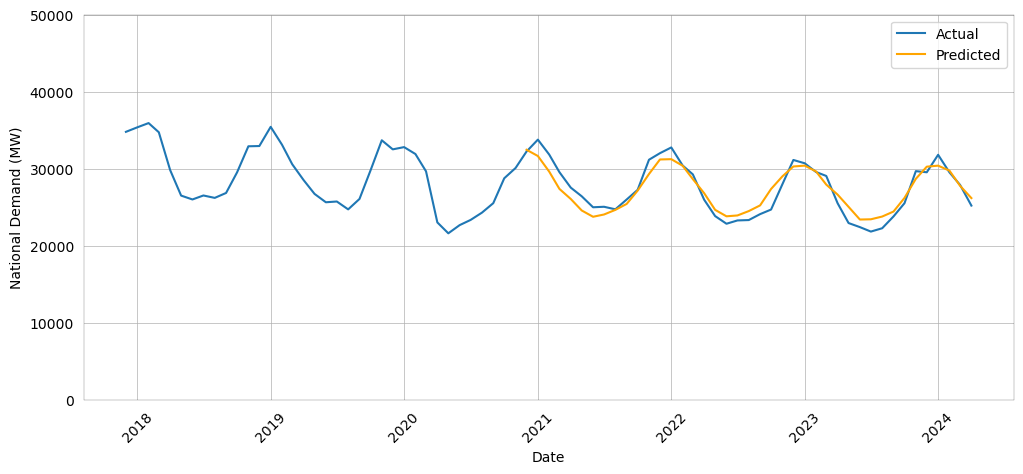

MAPE: 3.884%


In [28]:
plot_fcast_ml(agg_ltoc, "2017-12-01", "2020-12-01", "2024-05-01", pred_ltoc, False)

print(f"MAPE: {mean_absolute_percentage_error(yts_ltoc, pred_ltoc)*100:.3f}%")

This process will be repeated 7 more times with LSTM/GRU and `..oc`, `..mc` inputs.

### LTLF with Exogenous Variables

In [29]:
def df_Xy(df: DataFrame, seasonal_order: int) -> (np.ndarray, np.ndarray):
  X = []
  y = []
  for i in range(len(df)-seasonal_order):
    row = [a for a in df[i:i+seasonal_order]]
    X.append(row)
    label = df[i+seasonal_order]
    y.append(label)
  return np.array(X), np.array(y)

This is a modified col_Xy built for `..mc` datasets.

In [30]:
ltmc = ltoc[ltoc.index >= pd.to_datetime("2011-01-01")].join(mean_wdat).asfreq("MS")

In [31]:
scaler_ltmc = MinMaxScaler(feature_range=(0, 1))

sctr_ltmc = scaler_ltmc.fit_transform(ltmc[ltmc.index < pd.to_datetime("2017-01-01")])
scvl_ltmc = scaler_ltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2017-01-01")) & (ltmc.index < pd.to_datetime("2020-01-01"))])
scts_ltmc = scaler_ltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2020-01-01")) & (ltmc.index < pd.to_datetime("2024-05-01"))])

Xtr_ltmc, ytr_ltmc = df_Xy(sctr_ltmc, SEASON_LTLF)
Xvl_ltmc, yvl_ltmc = df_Xy(scvl_ltmc, SEASON_LTLF)
Xts_ltmc, yts_ltmc = df_Xy(scts_ltmc, SEASON_LTLF)

In [32]:
ltmc_model = Sequential()
ltmc_model.add(InputLayer((SEASON_LTLF, 4)))
ltmc_model.add(LSTM(512, return_sequences=True))
ltmc_model.add(LSTM(256))
ltmc_model.add(Dense(32, 'relu'))
ltmc_model.add(Dense(4, 'linear'))

ltmc_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 11, 512)        │     1,058,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,854,628 (7.07 MB)

 Trainable params: 1,854,628 (7.07 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
cp = ModelCheckpoint('models/ltmc_model.keras', save_best_only=True)
ltmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

ltmc_model.fit(Xtr_ltmc, ytr_ltmc, validation_data=(Xvl_ltmc, yvl_ltmc), epochs=50, callbacks=[cp])

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 483ms/step - loss: 0.2345 - root_mean_squared_error: 0.4842 - val_loss: 0.2094 - val_root_mean_squared_error: 0.4576
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.1436 - root_mean_squared_error: 0.3786 - val_loss: 0.1509 - val_root_mean_squared_error: 0.3885
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.1001 - root_mean_squared_error: 0.3161 - val_loss: 0.1037 - val_root_mean_squared_error: 0.3220
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0709 - root_mean_squared_error: 0.2661 - val_loss: 0.0968 - val_root_mean_squared_error: 0.3111
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0656 - root_mean_squared_error: 0.2561 - val_loss: 0.0829 - val_root_mean_squared_error: 0.2880
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0583 - root_mean_squared_error: 0.2413 - val_loss: 0.0871 - val_root_mean_squared_error: 0.2952
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0579 

In [34]:
ltmc_model = load_model('models/ltmc_model.keras')
pred_ltmc = ltmc_model.predict(Xts_ltmc)
pred_ltmc = scaler_ltmc.inverse_transform(pred_ltmc)[:,0]

yts_ltmc = scaler_ltmc.inverse_transform(yts_ltmc)[:,0]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


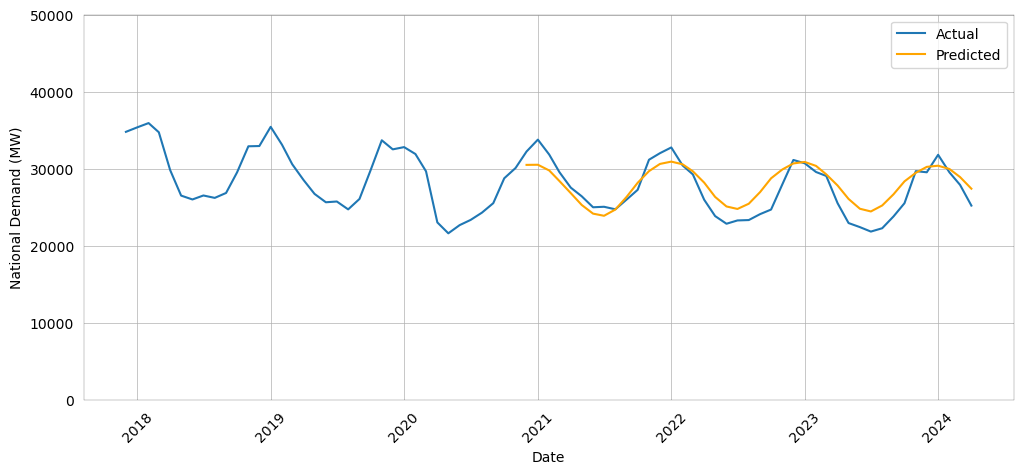

MAPE: 6.091%


In [35]:
plot_fcast_ml(ltmc, "2017-12-01", "2020-12-01", "2024-05-01", pred_ltmc, True)

print(f"MAPE: {mean_absolute_percentage_error(yts_ltmc, pred_ltmc)*100:.3f}%")

### STLF

In [36]:
SEASON_STLF = 6

In [37]:
stoc = df[["YMD", "ND"]].groupby("YMD").agg("mean").asfreq("D")

In [38]:
w_start = datetime.datetime(2022, 1, 1)
w_end = datetime.datetime(2022, 12, 31)

In [39]:
ldn_dwdat = met.Daily(ldn, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
edi_dwdat = met.Daily(edi, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
cdf_dwdat = met.Daily(cdf, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]

In [40]:
sun_dfactor = df[["YMD", "sun_eff"]].groupby("YMD").agg("mean").asfreq("D")
sun_ddata = sun_dfactor[(sun_dfactor.index >= pd.to_datetime("2022-01-01")) & (sun_dfactor.index <= pd.to_datetime("2022-12-31"))]

combined_dwdat = pd.concat([ldn_dwdat, edi_dwdat, cdf_dwdat, sun_ddata], axis=1)

mean_dwdat = combined_dwdat.T.groupby(combined_dwdat.columns).agg("mean").T

In [41]:
agg_stoc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].asfreq("D")

In [42]:
scaler_stoc = MinMaxScaler(feature_range=(0, 1))

sctr_stoc = scaler_stoc.fit_transform(agg_stoc[agg_stoc.index < pd.to_datetime("2022-05-01")])
scvl_stoc = scaler_stoc.fit_transform(agg_stoc[(agg_stoc.index >= pd.to_datetime("2022-05-01")) & (agg_stoc.index < pd.to_datetime("2022-07-15"))])
scts_stoc = scaler_stoc.fit_transform(agg_stoc[agg_stoc.index >= pd.to_datetime("2022-07-15")])

Xtr_stoc, ytr_stoc = df_Xy(sctr_stoc, SEASON_STLF)
Xvl_stoc, yvl_stoc = df_Xy(scvl_stoc, SEASON_STLF)
Xts_stoc, yts_stoc = df_Xy(scts_stoc, SEASON_STLF)

In [43]:
stoc_model = Sequential()
stoc_model.add(InputLayer((SEASON_STLF, 1)))
stoc_model.add(LSTM(256, return_sequences=True))
stoc_model.add(LSTM(256))
stoc_model.add(Dense(8, 'relu'))
stoc_model.add(Dense(1, 'linear'))

stoc_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 6, 256)         │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 791,569 (3.02 MB)

 Trainable params: 791,569 (3.02 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
cp = ModelCheckpoint('models/stoc_model.keras', save_best_only=True)
stoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

stoc_model.fit(Xtr_stoc, ytr_stoc, validation_data=(Xvl_stoc, yvl_stoc), epochs=50, callbacks=[cp])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.2427 - root_mean_squared_error: 0.4916 - val_loss: 0.0544 - val_root_mean_squared_error: 0.2332
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0504 - root_mean_squared_error: 0.2229 - val_loss: 0.0658 - val_root_mean_squared_error: 0.2566
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0330 - root_mean_squared_error: 0.1815 - val_loss: 0.0617 - val_root_mean_squared_error: 0.2484
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0461 - root_mean_squared_error: 0.2136 - val_loss: 0.0553 - val_root_mean_squared_error: 0.2353
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0286 - root_mean_squared_error: 0.1691 - val_loss: 0.0632 - val_root_mean_squared_error: 0.2514
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0291 - root_mean_squared_error: 0.1705 - val_loss: 0.0535 - val_root_mean_squared_error: 0.2313
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0274 - root

In [45]:
stoc_model = load_model('models/stoc_model.keras')

pred_stoc = stoc_model.predict(Xts_stoc)
pred_stoc = scaler_stoc.inverse_transform(pred_stoc)

yts_stoc = scaler_stoc.inverse_transform(yts_stoc)

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/stepWARNING:tensorflow:6 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7a2126b3ec00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


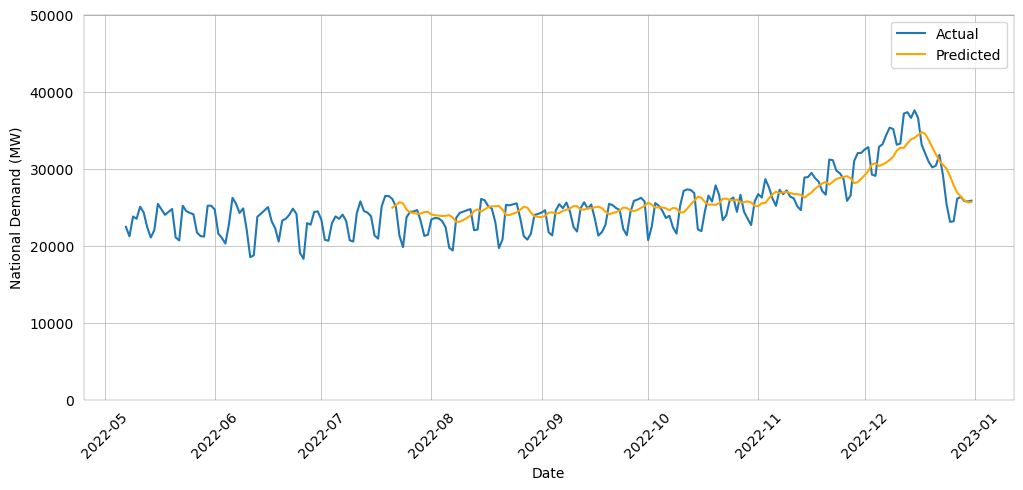

MAPE: 7.151%


In [46]:
plot_fcast_ml(agg_stoc, "2022-05-07", "2022-07-21", "2023-01-01", pred_stoc, False)

print(f"MAPE: {mean_absolute_percentage_error(yts_stoc, pred_stoc)*100:.3f}%")

### STLF with Exogenous Variables

In [47]:
stmc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].join(mean_dwdat).asfreq("D")

In [48]:
scaler_stmc = MinMaxScaler(feature_range=(0, 1))

sctr_stmc = scaler_stmc.fit_transform(stmc[stmc.index < pd.to_datetime("2022-05-01")])
scvl_stmc = scaler_stmc.fit_transform(stmc[(stmc.index >= pd.to_datetime("2022-05-01")) & (stmc.index < pd.to_datetime("2022-07-15"))])
scts_stmc = scaler_stmc.fit_transform(stmc[stmc.index >= pd.to_datetime("2022-07-15")])

Xtr_stmc, ytr_stmc = df_Xy(sctr_stmc, SEASON_STLF)
Xvl_stmc, yvl_stmc = df_Xy(scvl_stmc, SEASON_STLF)
Xts_stmc, yts_stmc = df_Xy(scts_stmc, SEASON_STLF)

In [49]:
stmc_model = Sequential()
stmc_model.add(InputLayer((SEASON_STLF, 4)))
stmc_model.add(LSTM(512, return_sequences=True))
stmc_model.add(LSTM(512))
stmc_model.add(Dense(32, 'relu'))
stmc_model.add(Dense(4, 'linear'))

stmc_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 6, 512)         │     1,058,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,174,564 (12.11 MB)

 Trainable params: 3,174,564 (12.11 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
cp = ModelCheckpoint('models/stmc_model.keras', save_best_only=True)
stmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

stmc_model.fit(Xtr_stmc, ytr_stmc, validation_data=(Xvl_stmc, yvl_stmc), epochs=50, callbacks=[cp])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.1929 - root_mean_squared_error: 0.4369 - val_loss: 0.1241 - val_root_mean_squared_error: 0.3523
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0825 - root_mean_squared_error: 0.2853 - val_loss: 0.0889 - val_root_mean_squared_error: 0.2982
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0581 - root_mean_squared_error: 0.2408 - val_loss: 0.0587 - val_root_mean_squared_error: 0.2422
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0392 - root_mean_squared_error: 0.1978 - val_loss: 0.0597 - val_root_mean_squared_error: 0.2443
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0365 - root_mean_squared_error: 0.1910 - val_loss: 0.0614 - val_root_mean_squared_error: 0.2478
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0355 - root_mean_squared_error: 0.1884 - val_loss: 0.0589 - val_root_mean_squared_error: 0.2427
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0309 - r

In [51]:
stmc_model = load_model('models/stmc_model.keras')

pred_stmc = stmc_model.predict(Xts_stmc)
pred_stmc = scaler_stmc.inverse_transform(pred_stmc)[:,0]

yts_stmc = scaler_stmc.inverse_transform(yts_stmc)[:,0]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


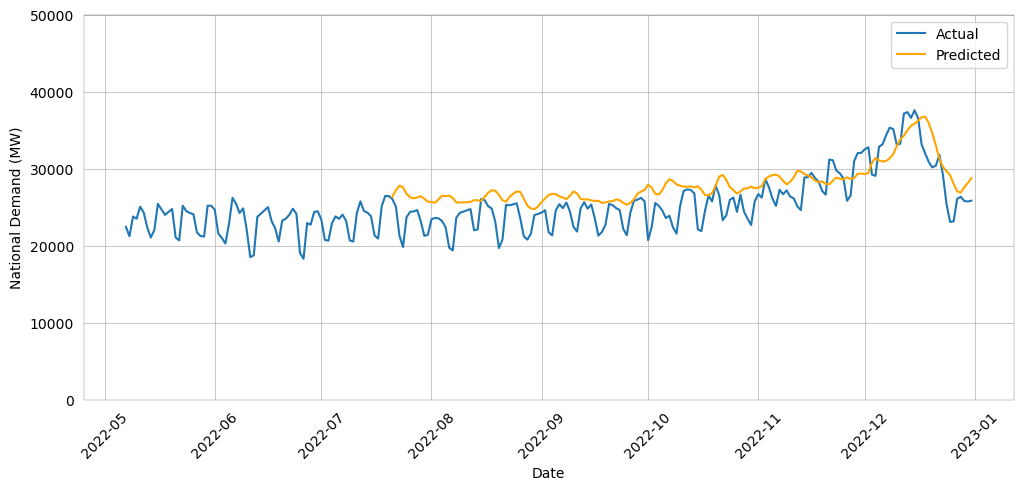

MAPE: 10.252%


In [52]:
plot_fcast_ml(stmc, "2022-05-07", "2022-07-21", "2023-01-01", pred_stmc, True)

print(f"MAPE: {mean_absolute_percentage_error(yts_stmc, pred_stmc)*100:.3f}%")

## GRU (Gated Recurrent Unit)

### LTLF

In [53]:
scaler_gltoc = MinMaxScaler(feature_range=(0, 1))

In [54]:
agg_gltoc = ltoc[ltoc.index >= pd.to_datetime("2009-01-01")].asfreq("MS")
sctr_gltoc = scaler_gltoc.fit_transform(agg_gltoc[agg_gltoc.index < pd.to_datetime("2017-01-01")])
scvl_gltoc = scaler_gltoc.fit_transform(agg_gltoc[(agg_gltoc.index >= pd.to_datetime("2017-01-01")) & (agg_gltoc.index < pd.to_datetime("2020-01-01"))])
scts_gltoc = scaler_gltoc.fit_transform(agg_gltoc[(agg_gltoc.index >= pd.to_datetime("2020-01-01")) & (agg_gltoc.index < pd.to_datetime("2024-05-01"))])

In [55]:
Xtr_gltoc, ytr_gltoc = col_Xy(sctr_gltoc, SEASON_LTLF)
Xvl_gltoc, yvl_gltoc = col_Xy(scvl_gltoc, SEASON_LTLF)
Xts_gltoc, yts_gltoc = col_Xy(scts_gltoc, SEASON_LTLF)

In [56]:
gltoc_model = Sequential()
gltoc_model.add(InputLayer((SEASON_LTLF, 1)))
gltoc_model.add(GRU(128, return_sequences=True))
gltoc_model.add(GRU(128))
gltoc_model.add(Dense(8, 'relu'))
gltoc_model.add(Dense(1, 'linear'))

In [57]:
cp = ModelCheckpoint('models/gltoc_model.keras', save_best_only=True)
gltoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [58]:
gltoc_model.fit(Xtr_gltoc, ytr_gltoc, validation_data=(Xvl_gltoc, yvl_gltoc), epochs=50, callbacks=[cp])

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.1767 - root_mean_squared_error: 0.4195 - val_loss: 0.1135 - val_root_mean_squared_error: 0.3370
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0685 - root_mean_squared_error: 0.2616 - val_loss: 0.1399 - val_root_mean_squared_error: 0.3740
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0773 - root_mean_squared_error: 0.2780 - val_loss: 0.1055 - val_root_mean_squared_error: 0.3248
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0545 - root_mean_squared_error: 0.2333 - val_loss: 0.1003 - val_root_mean_squared_error: 0.3168
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0572 - root_mean_squared_error: 0.2391 - val_loss: 0.0974 - val_root_mean_squared_error: 0.3120
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0517 - root_mean_squared_error: 0.2272 - val_loss: 0.0889 - val_root_mean_squared_error: 0.2982
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0520 - roo

In [59]:
gltoc_model = load_model('models/gltoc_model.keras')

pred_gltoc = gltoc_model.predict(Xts_gltoc)
pred_gltoc = scaler_gltoc.inverse_transform(pred_gltoc)

yts_gltoc = scaler_gltoc.inverse_transform(yts_gltoc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


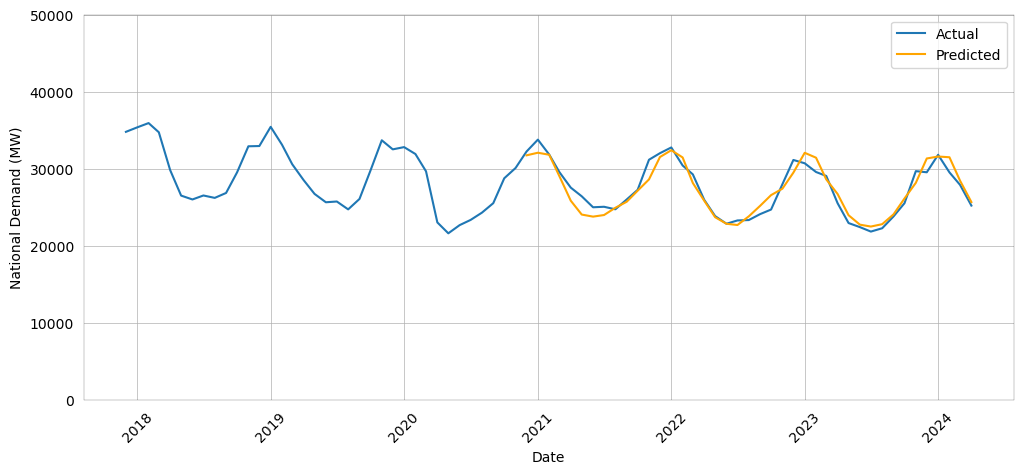

MAPE: 3.227%


In [60]:
plot_fcast_ml(agg_gltoc, "2017-12-01", "2020-12-01", "2024-05-01", pred_gltoc, False)

print(f"MAPE: {mean_absolute_percentage_error(yts_gltoc, pred_gltoc)*100:.3f}%")

### LTLF with Exogenous Variables

In [61]:
scaler_gltmc = MinMaxScaler(feature_range=(0, 1))

sctr_gltmc = scaler_gltmc.fit_transform(ltmc[ltmc.index < pd.to_datetime("2017-01-01")])
scvl_gltmc = scaler_gltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2017-01-01")) & (ltmc.index < pd.to_datetime("2020-01-01"))])
scts_gltmc = scaler_gltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2020-01-01")) & (ltmc.index < pd.to_datetime("2024-05-01"))])

Xtr_gltmc, ytr_gltmc = df_Xy(sctr_gltmc, SEASON_LTLF)
Xvl_gltmc, yvl_gltmc = df_Xy(scvl_gltmc, SEASON_LTLF)
Xts_gltmc, yts_gltmc = df_Xy(scts_gltmc, SEASON_LTLF)

In [62]:
gltmc_model = Sequential()
gltmc_model.add(InputLayer((SEASON_LTLF, 4)))
gltmc_model.add(GRU(512, return_sequences=True))
gltmc_model.add(GRU(256))
gltmc_model.add(Dense(32, 'relu'))
gltmc_model.add(Dense(4, 'linear'))

gltmc_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 11, 512)        │       795,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 256)            │       591,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,395,364 (5.32 MB)

 Trainable params: 1,395,364 (5.32 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
cp = ModelCheckpoint('models/gltmc_model.keras', save_best_only=True)
gltmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

gltmc_model.fit(Xtr_gltmc, ytr_gltmc, validation_data=(Xvl_gltmc, yvl_gltmc), epochs=50, callbacks=[cp])

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 577ms/step - loss: 0.1933 - root_mean_squared_error: 0.4384 - val_loss: 0.0836 - val_root_mean_squared_error: 0.2892
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0632 - root_mean_squared_error: 0.2510 - val_loss: 0.0742 - val_root_mean_squared_error: 0.2723
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0487 - root_mean_squared_error: 0.2207 - val_loss: 0.0586 - val_root_mean_squared_error: 0.2420
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0404 - root_mean_squared_error: 0.2011 - val_loss: 0.0488 - val_root_mean_squared_error: 0.2208
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0300 - root_mean_squared_error: 0.1731 - val_loss: 0.0349 - val_root_mean_squared_error: 0.1867
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0204 - root_mean_squared_error: 0.1428 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1525
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0212 

In [64]:
gltmc_model = load_model('models/gltmc_model.keras')

pred_gltmc = gltmc_model.predict(Xts_gltmc)
pred_gltmc = scaler_gltmc.inverse_transform(pred_gltmc)[:,0]

yts_gltmc = scaler_gltmc.inverse_transform(yts_gltmc)[:,0]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


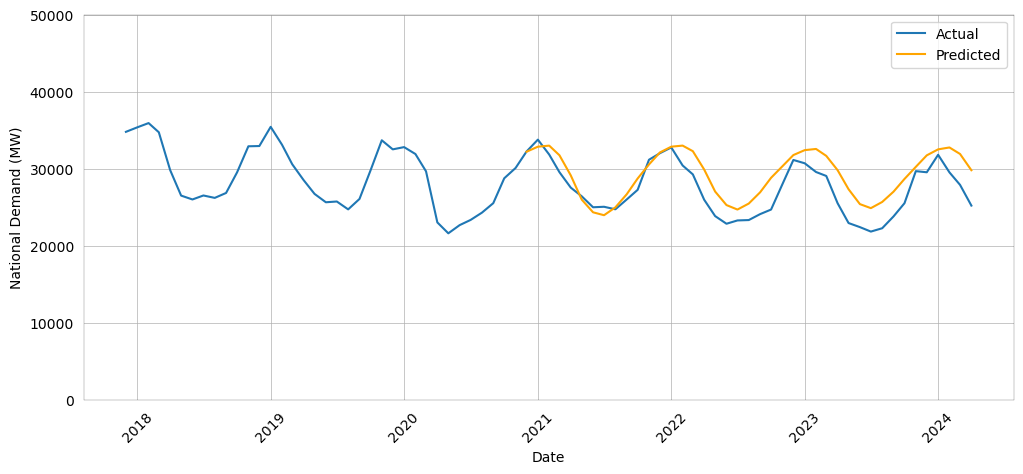

MAPE: 8.194%


In [65]:
plot_fcast_ml(ltmc, "2017-12-01", "2020-12-01", "2024-05-01", pred_gltmc, True)

print(f"MAPE: {mean_absolute_percentage_error(yts_gltmc, pred_gltmc)*100:.3f}%")

### STLF

In [66]:
scaler_gstoc = MinMaxScaler(feature_range=(0, 1))

sctr_gstoc = scaler_gstoc.fit_transform(agg_stoc[agg_stoc.index < pd.to_datetime("2022-05-01")])
scvl_gstoc = scaler_gstoc.fit_transform(agg_stoc[(agg_stoc.index >= pd.to_datetime("2022-05-01")) & (agg_stoc.index < pd.to_datetime("2022-07-15"))])
scts_gstoc = scaler_gstoc.fit_transform(agg_stoc[agg_stoc.index >= pd.to_datetime("2022-07-15")])

Xtr_gstoc, ytr_gstoc = df_Xy(sctr_gstoc, SEASON_STLF)
Xvl_gstoc, yvl_gstoc = df_Xy(scvl_gstoc, SEASON_STLF)
Xts_gstoc, yts_gstoc = df_Xy(scts_gstoc, SEASON_STLF)

In [67]:
gstoc_model = Sequential()
gstoc_model.add(InputLayer((SEASON_STLF, 1)))
gstoc_model.add(GRU(256, return_sequences=True))
gstoc_model.add(GRU(256))
gstoc_model.add(Dense(8, 'relu'))
gstoc_model.add(Dense(1, 'linear'))

gstoc_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 6, 256)         │       198,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 595,729 (2.27 MB)

 Trainable params: 595,729 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
cp = ModelCheckpoint('models/gstoc_model.keras', save_best_only=True)
gstoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

gstoc_model.fit(Xtr_gstoc, ytr_gstoc, validation_data=(Xvl_gstoc, yvl_gstoc), epochs=50, callbacks=[cp])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.5890 - root_mean_squared_error: 0.7610 - val_loss: 0.2799 - val_root_mean_squared_error: 0.5290
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2447 - root_mean_squared_error: 0.4893 - val_loss: 0.3857 - val_root_mean_squared_error: 0.6211
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4475 - root_mean_squared_error: 0.6652 - val_loss: 0.0513 - val_root_mean_squared_error: 0.2264
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1010 - root_mean_squared_error: 0.3129 - val_loss: 0.1432 - val_root_mean_squared_error: 0.3785
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1154 - root_mean_squared_error: 0.3388 - val_loss: 0.0517 - val_root_mean_squared_error: 0.2273
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0705 - root_mean_squared_error: 0.2654 - val_loss: 0.0421 - val_root_mean_squared_error: 0.2052
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0366 - root

In [69]:
gstoc_model = load_model('models/gstoc_model.keras')

pred_gstoc = gstoc_model.predict(Xts_gstoc)
pred_gstoc = scaler_gstoc.inverse_transform(pred_gstoc)

yts_gstoc = scaler_gstoc.inverse_transform(yts_gstoc)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


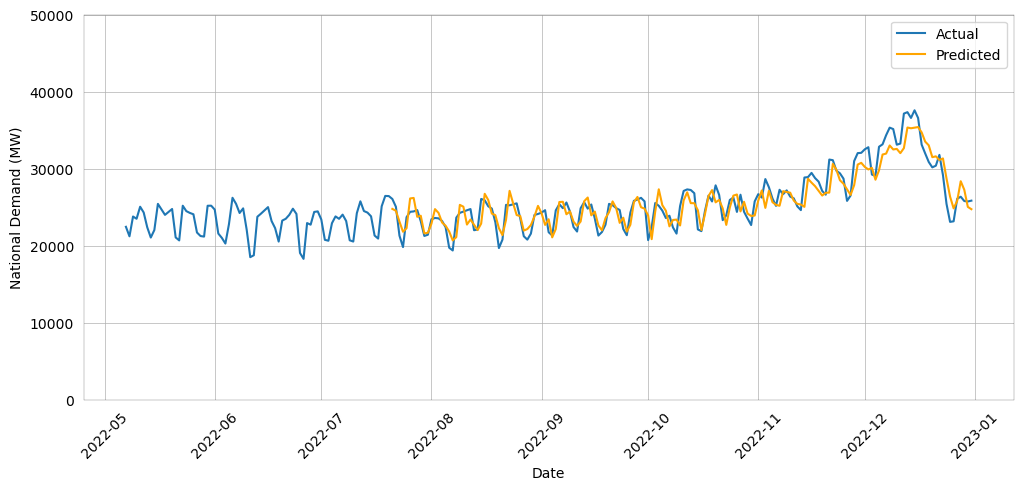

MAPE: 4.810%


In [70]:
plot_fcast_ml(agg_stoc, "2022-05-07", "2022-07-21", "2023-01-01", pred_gstoc, False)

print(f"MAPE: {mean_absolute_percentage_error(yts_gstoc, pred_gstoc)*100:.3f}%")

### STLF with Exogenous Variables

In [71]:
scaler_gstmc = MinMaxScaler(feature_range=(0, 1))

sctr_gstmc = scaler_gstmc.fit_transform(stmc[stmc.index < pd.to_datetime("2022-05-01")])
scvl_gstmc = scaler_gstmc.fit_transform(stmc[(stmc.index >= pd.to_datetime("2022-05-01")) & (stmc.index < pd.to_datetime("2022-07-15"))])
scts_gstmc = scaler_gstmc.fit_transform(stmc[stmc.index >= pd.to_datetime("2022-07-15")])

Xtr_gstmc, ytr_gstmc = df_Xy(sctr_gstmc, SEASON_STLF)
Xvl_gstmc, yvl_gstmc = df_Xy(scvl_gstmc, SEASON_STLF)
Xts_gstmc, yts_gstmc = df_Xy(scts_gstmc, SEASON_STLF)

In [72]:
gstmc_model = Sequential()
gstmc_model.add(InputLayer((SEASON_STLF, 4)))
gstmc_model.add(GRU(512, return_sequences=True))
gstmc_model.add(GRU(512))
gstmc_model.add(Dense(32, 'relu'))
gstmc_model.add(Dense(4, 'linear'))

gstmc_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 6, 512)         │       795,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 512)            │     1,575,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,388,132 (9.11 MB)

 Trainable params: 2,388,132 (9.11 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
cp = ModelCheckpoint('models/gstmc_model.keras', save_best_only=True)
gstmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

gstmc_model.fit(Xtr_gstmc, ytr_gstmc, validation_data=(Xvl_gstmc, yvl_gstmc), epochs=50, callbacks=[cp])


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.1697 - root_mean_squared_error: 0.4082 - val_loss: 0.0971 - val_root_mean_squared_error: 0.3116
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0533 - root_mean_squared_error: 0.2306 - val_loss: 0.0664 - val_root_mean_squared_error: 0.2576
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0486 - root_mean_squared_error: 0.2199 - val_loss: 0.0608 - val_root_mean_squared_error: 0.2465
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0312 - root_mean_squared_error: 0.1765 - val_loss: 0.0590 - val_root_mean_squared_error: 0.2429
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0297 - root_mean_squared_error: 0.1723 - val_loss: 0.0584 - val_root_mean_squared_error: 0.2417
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0290 - root_mean_squared_error: 0.1701 - val_loss: 0.0562 - val_root_mean_squared_error: 0.2372
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0268 - roo

In [74]:
gstmc_model = load_model('models/gstmc_model.keras')

pred_gstmc = gstmc_model.predict(Xts_gstmc)
pred_gstmc = scaler_gstmc.inverse_transform(pred_gstmc)[:,0]

yts_gstmc = scaler_gstmc.inverse_transform(yts_gstmc)[:,0]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


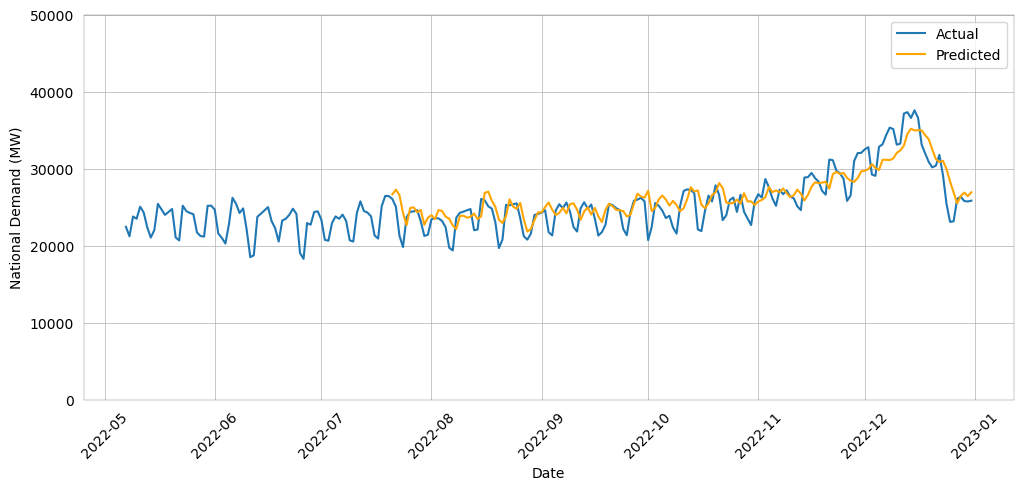

MAPE: 6.540%


In [75]:
plot_fcast_ml(stmc, "2022-05-07", "2022-07-21", "2023-01-01", pred_gstmc, True)

print(f"MAPE: {mean_absolute_percentage_error(yts_gstmc, pred_gstmc)*100:.3f}%")

## MAPE Averaging

WARNING: do not run unless you are willing to wait for 1.5 - 3hrs (depending on hardware)!

In [76]:
def ltoc_run() -> float:
    scaler_ltoc = MinMaxScaler(feature_range=(0, 1))
    agg_ltoc = ltoc[ltoc.index >= pd.to_datetime("2009-01-01")].asfreq("MS")
    sctr_ltoc = scaler_ltoc.fit_transform(agg_ltoc[agg_ltoc.index < pd.to_datetime("2017-01-01")])
    scvl_ltoc = scaler_ltoc.fit_transform(agg_ltoc[(agg_ltoc.index >= pd.to_datetime("2017-01-01")) & (agg_ltoc.index < pd.to_datetime("2020-01-01"))])
    scts_ltoc = scaler_ltoc.fit_transform(agg_ltoc[(agg_ltoc.index >= pd.to_datetime("2020-01-01")) & (agg_ltoc.index < pd.to_datetime("2024-05-01"))])
    Xtr_ltoc, ytr_ltoc = col_Xy(sctr_ltoc, SEASON_LTLF)
    Xvl_ltoc, yvl_ltoc = col_Xy(scvl_ltoc, SEASON_LTLF)
    Xts_ltoc, yts_ltoc = col_Xy(scts_ltoc, SEASON_LTLF)
    ltoc_model = Sequential()
    ltoc_model.add(InputLayer((SEASON_LTLF, 1)))
    ltoc_model.add(LSTM(128, return_sequences=True))
    ltoc_model.add(LSTM(128))
    ltoc_model.add(Dense(8, 'relu'))
    ltoc_model.add(Dense(1, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    ltoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    ltoc_model.fit(Xtr_ltoc, ytr_ltoc, validation_data=(Xvl_ltoc, yvl_ltoc), epochs=50, callbacks=[cp])
    ltoc_model = load_model('intermediate.keras')
    pred_ltoc = ltoc_model.predict(Xts_ltoc)
    pred_ltoc = scaler_ltoc.inverse_transform(pred_ltoc)
    yts_ltoc = scaler_ltoc.inverse_transform(yts_ltoc)
   
    return mean_absolute_percentage_error(yts_ltoc, pred_ltoc) * 100

In [77]:
def gltoc_run() -> float:
    scaler_gltoc = MinMaxScaler(feature_range=(0, 1))
    agg_gltoc = ltoc[ltoc.index >= pd.to_datetime("2009-01-01")].asfreq("MS")
    sctr_gltoc = scaler_gltoc.fit_transform(agg_gltoc[agg_gltoc.index < pd.to_datetime("2017-01-01")])
    scvl_gltoc = scaler_gltoc.fit_transform(agg_gltoc[(agg_gltoc.index >= pd.to_datetime("2017-01-01")) & (agg_gltoc.index < pd.to_datetime("2020-01-01"))])
    scts_gltoc = scaler_gltoc.fit_transform(agg_gltoc[(agg_gltoc.index >= pd.to_datetime("2020-01-01")) & (agg_gltoc.index < pd.to_datetime("2024-05-01"))])
    Xtr_gltoc, ytr_gltoc = col_Xy(sctr_gltoc, SEASON_LTLF)
    Xvl_gltoc, yvl_gltoc = col_Xy(scvl_gltoc, SEASON_LTLF)
    Xts_gltoc, yts_gltoc = col_Xy(scts_gltoc, SEASON_LTLF)
    gltoc_model = Sequential()
    gltoc_model.add(InputLayer((SEASON_LTLF, 1)))
    gltoc_model.add(GRU(128, return_sequences=True))
    gltoc_model.add(GRU(128))
    gltoc_model.add(Dense(8, 'relu'))
    gltoc_model.add(Dense(1, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    gltoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    gltoc_model.fit(Xtr_gltoc, ytr_gltoc, validation_data=(Xvl_gltoc, yvl_gltoc), epochs=50, callbacks=[cp])
    gltoc_model = load_model('intermediate.keras')
    pred_gltoc = gltoc_model.predict(Xts_gltoc)
    pred_gltoc = scaler_gltoc.inverse_transform(pred_gltoc)
    yts_gltoc = scaler_gltoc.inverse_transform(yts_gltoc)
   
    return mean_absolute_percentage_error(yts_gltoc, pred_gltoc) * 100

In [78]:
def stoc_run() -> float:
    agg_stoc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].asfreq("D")
    scaler_stoc = MinMaxScaler(feature_range=(0, 1))
    sctr_stoc = scaler_stoc.fit_transform(stoc[stoc.index < pd.to_datetime("2022-05-01")])
    scvl_stoc = scaler_stoc.fit_transform(stoc[(stoc.index >= pd.to_datetime("2022-05-01")) & (stoc.index < pd.to_datetime("2022-07-15"))])
    scts_stoc = scaler_stoc.fit_transform(stoc[stoc.index >= pd.to_datetime("2022-07-15")])
    Xtr_stoc, ytr_stoc = df_Xy(sctr_stoc, SEASON_STLF)
    Xvl_stoc, yvl_stoc = df_Xy(scvl_stoc, SEASON_STLF)
    Xts_stoc, yts_stoc = df_Xy(scts_stoc, SEASON_STLF)
    stoc_model = Sequential()
    stoc_model.add(InputLayer((SEASON_STLF, 1)))
    stoc_model.add(LSTM(256, return_sequences=True))
    stoc_model.add(LSTM(256))
    stoc_model.add(Dense(8, 'relu'))
    stoc_model.add(Dense(1, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    stoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    stoc_model.fit(Xtr_stoc, ytr_stoc, validation_data=(Xvl_stoc, yvl_stoc), epochs=50, callbacks=[cp])
    stoc_model = load_model('intermediate.keras')
    pred_stoc = stoc_model.predict(Xts_stoc)
    pred_stoc = scaler_stoc.inverse_transform(pred_stoc)
    yts_stoc = scaler_stoc.inverse_transform(yts_stoc)
    

    return mean_absolute_percentage_error(yts_stoc, pred_stoc) * 100

In [79]:
def gstoc_run() -> float:
    agg_gstoc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].asfreq("D")
    scaler_gstoc = MinMaxScaler(feature_range=(0, 1))
    sctr_gstoc = scaler_gstoc.fit_transform(agg_gstoc[agg_gstoc.index < pd.to_datetime("2022-05-01")])
    scvl_gstoc = scaler_gstoc.fit_transform(agg_gstoc[(agg_gstoc.index >= pd.to_datetime("2022-05-01")) & (agg_gstoc.index < pd.to_datetime("2022-07-15"))])
    scts_gstoc = scaler_gstoc.fit_transform(agg_gstoc[agg_gstoc.index >= pd.to_datetime("2022-07-15")])
    Xtr_gstoc, ytr_gstoc = df_Xy(sctr_gstoc, SEASON_STLF)
    Xvl_gstoc, yvl_gstoc = df_Xy(scvl_gstoc, SEASON_STLF)
    Xts_gstoc, yts_gstoc = df_Xy(scts_gstoc, SEASON_STLF)
    gstoc_model = Sequential()
    gstoc_model.add(InputLayer((SEASON_STLF, 1)))
    gstoc_model.add(GRU(256, return_sequences=True))
    gstoc_model.add(GRU(256))
    gstoc_model.add(Dense(8, 'relu'))
    gstoc_model.add(Dense(1, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    gstoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    gstoc_model.fit(Xtr_gstoc, ytr_gstoc, validation_data=(Xvl_gstoc, yvl_gstoc), epochs=50, callbacks=[cp])
    gstoc_model = load_model('intermediate.keras')
    pred_gstoc = gstoc_model.predict(Xts_gstoc)
    pred_gstoc = scaler_gstoc.inverse_transform(pred_gstoc)
    yts_gstoc = scaler_gstoc.inverse_transform(yts_gstoc)
    
    return mean_absolute_percentage_error(yts_gstoc, pred_gstoc) * 100

In [80]:
def ltmc_run() -> float:
    ltmc = ltoc[ltoc.index >= pd.to_datetime("2011-01-01")].join(mean_wdat).asfreq("MS")
    scaler_ltmc = MinMaxScaler(feature_range=(0, 1))
    sctr_ltmc = scaler_ltmc.fit_transform(ltmc[ltmc.index < pd.to_datetime("2017-01-01")])
    scvl_ltmc = scaler_ltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2017-01-01")) & (ltmc.index < pd.to_datetime("2020-01-01"))])
    scts_ltmc = scaler_ltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2020-01-01")) & (ltmc.index < pd.to_datetime("2024-05-01"))])
    Xtr_ltmc, ytr_ltmc = df_Xy(sctr_ltmc, SEASON_LTLF)
    Xvl_ltmc, yvl_ltmc = df_Xy(scvl_ltmc, SEASON_LTLF)
    Xts_ltmc, yts_ltmc = df_Xy(scts_ltmc, SEASON_LTLF)
    ltmc_model = Sequential()
    ltmc_model.add(InputLayer((SEASON_LTLF, 4)))
    ltmc_model.add(LSTM(512, return_sequences=True))
    ltmc_model.add(LSTM(256))
    ltmc_model.add(Dense(32, 'relu'))
    ltmc_model.add(Dense(4, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    ltmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    ltmc_model.fit(Xtr_ltmc, ytr_ltmc, validation_data=(Xvl_ltmc, yvl_ltmc), epochs=50, callbacks=[cp])
    ltmc_model = load_model('intermediate.keras')
    pred_ltmc = ltmc_model.predict(Xts_ltmc)
    pred_ltmc = scaler_ltmc.inverse_transform(pred_ltmc)[:,0]
    yts_ltmc = scaler_ltmc.inverse_transform(yts_ltmc)[:,0]

    return mean_absolute_percentage_error(yts_ltmc, pred_ltmc) * 100

In [81]:
def gltmc_run() -> float:
    gltmc = ltoc[ltoc.index >= pd.to_datetime("2011-01-01")].join(mean_wdat).asfreq("MS")
    scaler_gltmc = MinMaxScaler(feature_range=(0, 1))
    sctr_gltmc = scaler_gltmc.fit_transform(gltmc[gltmc.index < pd.to_datetime("2017-01-01")])
    scvl_gltmc = scaler_gltmc.fit_transform(gltmc[(gltmc.index >= pd.to_datetime("2017-01-01")) & (gltmc.index < pd.to_datetime("2020-01-01"))])
    scts_gltmc = scaler_gltmc.fit_transform(gltmc[(gltmc.index >= pd.to_datetime("2020-01-01")) & (gltmc.index < pd.to_datetime("2024-05-01"))])
    Xtr_gltmc, ytr_gltmc = df_Xy(sctr_gltmc, SEASON_LTLF)
    Xvl_gltmc, yvl_gltmc = df_Xy(scvl_gltmc, SEASON_LTLF)
    Xts_gltmc, yts_gltmc = df_Xy(scts_gltmc, SEASON_LTLF)
    gltmc_model = Sequential()
    gltmc_model.add(InputLayer((SEASON_LTLF, 4)))
    gltmc_model.add(LSTM(512, return_sequences=True))
    gltmc_model.add(LSTM(256))
    gltmc_model.add(Dense(32, 'relu'))
    gltmc_model.add(Dense(4, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    gltmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    gltmc_model.fit(Xtr_gltmc, ytr_gltmc, validation_data=(Xvl_gltmc, yvl_gltmc), epochs=50, callbacks=[cp])
    gltmc_model = load_model('intermediate.keras')
    pred_gltmc = gltmc_model.predict(Xts_gltmc)
    pred_gltmc = scaler_gltmc.inverse_transform(pred_gltmc)[:,0]
    yts_gltmc = scaler_gltmc.inverse_transform(yts_gltmc)[:,0]

    return mean_absolute_percentage_error(yts_gltmc, pred_gltmc) * 100

In [92]:
def stmc_run():
    stmc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].join(mean_dwdat).asfreq("D")
    scaler_stmc = MinMaxScaler(feature_range=(0, 1))
    sctr_stmc = scaler_stmc.fit_transform(stmc[stmc.index < pd.to_datetime("2022-05-01")])
    scvl_stmc = scaler_stmc.fit_transform(stmc[(stmc.index >= pd.to_datetime("2022-05-01")) & (stmc.index < pd.to_datetime("2022-07-15"))])
    scts_stmc = scaler_stmc.fit_transform(stmc[stmc.index >= pd.to_datetime("2022-07-15")])
    Xtr_stmc, ytr_stmc = df_Xy(sctr_stmc, SEASON_STLF)
    Xvl_stmc, yvl_stmc = df_Xy(scvl_stmc, SEASON_STLF)
    Xts_stmc, yts_stmc = df_Xy(scts_stmc, SEASON_STLF)
    stmc_model = Sequential()
    stmc_model.add(InputLayer((SEASON_STLF, 4)))
    stmc_model.add(LSTM(512, return_sequences=True))
    stmc_model.add(LSTM(512))
    stmc_model.add(Dense(32, 'relu'))
    stmc_model.add(Dense(4, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    stmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    stmc_model.fit(Xtr_stmc, ytr_stmc, validation_data=(Xvl_stmc, yvl_stmc), epochs=50, callbacks=[cp])
    stmc_model = load_model('intermediate.keras')
    pred_stmc = stmc_model.predict(Xts_stmc)
    pred_stmc = scaler_stmc.inverse_transform(pred_stmc)[:,0]
    yts_stmc = scaler_stmc.inverse_transform(yts_stmc)[:,0]

    return mean_absolute_percentage_error(yts_stmc, pred_stmc) * 100

In [93]:
def gstmc_run():
    gstmc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].join(mean_dwdat).asfreq("D")
    scaler_gstmc = MinMaxScaler(feature_range=(0, 1))
    sctr_gstmc = scaler_gstmc.fit_transform(gstmc[gstmc.index < pd.to_datetime("2022-05-01")])
    scvl_gstmc = scaler_gstmc.fit_transform(gstmc[(gstmc.index >= pd.to_datetime("2022-05-01")) & (gstmc.index < pd.to_datetime("2022-07-15"))])
    scts_gstmc = scaler_gstmc.fit_transform(gstmc[gstmc.index >= pd.to_datetime("2022-07-15")])
    Xtr_gstmc, ytr_gstmc = df_Xy(sctr_gstmc, SEASON_STLF)
    Xvl_gstmc, yvl_gstmc = df_Xy(scvl_gstmc, SEASON_STLF)
    Xts_gstmc, yts_gstmc = df_Xy(scts_gstmc, SEASON_STLF)
    gstmc_model = Sequential()
    gstmc_model.add(InputLayer((SEASON_STLF, 4)))
    gstmc_model.add(LSTM(512, return_sequences=True))
    gstmc_model.add(LSTM(512))
    gstmc_model.add(Dense(32, 'relu'))
    gstmc_model.add(Dense(4, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    gstmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    gstmc_model.fit(Xtr_gstmc, ytr_gstmc, validation_data=(Xvl_gstmc, yvl_gstmc), epochs=50, callbacks=[cp])
    gstmc_model = load_model('intermediate.keras')
    pred_gstmc = gstmc_model.predict(Xts_gstmc)
    pred_gstmc = scaler_gstmc.inverse_transform(pred_gstmc)[:,0]
    yts_gstmc = scaler_gstmc.inverse_transform(yts_gstmc)[:,0]

    return mean_absolute_percentage_error(yts_gstmc, pred_gstmc) * 100

In [84]:
""" 
results = {
    "ltoc":[], "gltoc":[], "stoc":[], "gstoc":[], "ltmc":[], "gltmc":[], "stmc":[], "gstmc":[]
    } """

In [85]:
""" 
for i in range(15):
    results["ltoc"].append(ltoc_run()) """

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.2504 - root_mean_squared_error: 0.5003 - val_loss: 0.2159 - val_root_mean_squared_error: 0.4646
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1627 - root_mean_squared_error: 0.4030 - val_loss: 0.1313 - val_root_mean_squared_error: 0.3624
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0804 - root_mean_squared_error: 0.2830 - val_loss: 0.1409 - val_root_mean_squared_error: 0.3753
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0886 - root_mean_squared_error: 0.2975 - val_loss: 0.1259 - val_root_mean_squared_error: 0.3549
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0620 - root_mean_squared_error: 0.2491 - val_loss: 0.1154 - val_root_mean_squared_error: 0.3398
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0624 - root_mean_squared_error: 0.2493 - val_loss: 0.1230 - val_root_mean_squared_error: 0.3508
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0795 - roo

In [86]:
""" 
for i in range(15):
    results["gltoc"].append(gltoc_run())
 """

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.1341 - root_mean_squared_error: 0.3656 - val_loss: 0.1242 - val_root_mean_squared_error: 0.3524
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0763 - root_mean_squared_error: 0.2762 - val_loss: 0.1083 - val_root_mean_squared_error: 0.3292
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0576 - root_mean_squared_error: 0.2399 - val_loss: 0.0915 - val_root_mean_squared_error: 0.3025
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0498 - root_mean_squared_error: 0.2227 - val_loss: 0.0867 - val_root_mean_squared_error: 0.2944
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0503 - root_mean_squared_error: 0.2241 - val_loss: 0.0749 - val_root_mean_squared_error: 0.2737
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0415 - root_mean_squared_error: 0.2037 - val_loss: 0.0724 - val_root_mean_squared_error: 0.2692
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0388 - roo

In [101]:
""" 
for i in range(15):
    results["stoc"].append(stoc_run())
    print(i)
 """

Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0373 - root_mean_squared_error: 0.1786 - val_loss: 0.0598 - val_root_mean_squared_error: 0.2445
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0551 - val_root_mean_squared_error: 0.2346
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0086 - root_mean_squared_error: 0.0925 - val_loss: 0.0492 - val_root_mean_squared_error: 0.2218
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0065 - root_mean_squared_error: 0.0809 - val_loss: 0.0304 - val_root_mean_squared_error: 0.1744
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0046 - root_mean_squared_error: 0.0681 - val_loss: 0.0251 - val_root_mean_squared_error: 0.1585
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0042 - root_mean_squared_error: 0.0651 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1593
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 11m

In [88]:
""" 
for i in range(15):
    results["gstoc"].append(gstoc_run())
    print(i)
 """

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.2527 - root_mean_squared_error: 0.4966 - val_loss: 0.1036 - val_root_mean_squared_error: 0.3219
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0629 - root_mean_squared_error: 0.2505 - val_loss: 0.0545 - val_root_mean_squared_error: 0.2335
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0325 - root_mean_squared_error: 0.1790 - val_loss: 0.0743 - val_root_mean_squared_error: 0.2725
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0524 - root_mean_squared_error: 0.2288 - val_loss: 0.0529 - val_root_mean_squared_error: 0.2301
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0237 - root_mean_squared_error: 0.1533 - val_loss: 0.0688 - val_root_mean_squared_error: 0.2623
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0361 - root_mean_squared_error: 0.1894 - val_loss: 0.0551 - val_root_mean_squared_error: 0.2347
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0258 - roo

In [103]:
""" 
for i in range(15):
    results["ltmc"].append(ltmc_run())
    print(i)
 """

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 376ms/step - loss: 0.2000 - root_mean_squared_error: 0.4464 - val_loss: 0.1072 - val_root_mean_squared_error: 0.3274
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0758 - root_mean_squared_error: 0.2754 - val_loss: 0.0871 - val_root_mean_squared_error: 0.2951
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0668 - root_mean_squared_error: 0.2583 - val_loss: 0.1009 - val_root_mean_squared_error: 0.3177
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0638 - root_mean_squared_error: 0.2525 - val_loss: 0.0845 - val_root_mean_squared_error: 0.2907
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0536 - root_mean_squared_error: 0.2314 - val_loss: 0.0700 - val_root_mean_squared_error: 0.2646
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0545 - root_mean_squared_error: 0.2333 - val_loss: 0.0636 - val_root_mean_squared_error: 0.2523
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0462 -

In [90]:
""" 
for i in range(15):
    results["gltmc"].append(gltmc_run())
    print(i)
 """

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - loss: 0.1966 - root_mean_squared_error: 0.4422 - val_loss: 0.1003 - val_root_mean_squared_error: 0.3166
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0784 - root_mean_squared_error: 0.2799 - val_loss: 0.0883 - val_root_mean_squared_error: 0.2971
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0623 - root_mean_squared_error: 0.2495 - val_loss: 0.1069 - val_root_mean_squared_error: 0.3270
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0716 - root_mean_squared_error: 0.2676 - val_loss: 0.0885 - val_root_mean_squared_error: 0.2975
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0560 - root_mean_squared_error: 0.2366 - val_loss: 0.0912 - val_root_mean_squared_error: 0.3020
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0577 - root_mean_squared_error: 0.2401 - val_loss: 0.0811 - val_root_mean_squared_error: 0.2847
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0517 - r

In [94]:
""" 
for i in range(15):
    results["stmc"].append(stmc_run())
    print(i)
 """

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - loss: 0.2186 - root_mean_squared_error: 0.4667 - val_loss: 0.0593 - val_root_mean_squared_error: 0.2435
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0682 - root_mean_squared_error: 0.2610 - val_loss: 0.0905 - val_root_mean_squared_error: 0.3009
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0489 - root_mean_squared_error: 0.2212 - val_loss: 0.0678 - val_root_mean_squared_error: 0.2604
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 0.0392 - root_mean_squared_error: 0.1977 - val_loss: 0.0548 - val_root_mean_squared_error: 0.2341
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0366 - root_mean_squared_error: 0.1912 - val_loss: 0.0619 - val_root_mean_squared_error: 0.2489
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0367 - root_mean_squared_error: 0.1916 - val_loss: 0.0659 - val_root_mean_squared_error: 0.2566
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0364 - ro

In [105]:
""" 
for i in range(15):
    results["gstmc"].append(gstmc_run())
    print(i)
 """

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.2267 - root_mean_squared_error: 0.4754 - val_loss: 0.0772 - val_root_mean_squared_error: 0.2778
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0695 - root_mean_squared_error: 0.2633 - val_loss: 0.0947 - val_root_mean_squared_error: 0.3078
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0458 - root_mean_squared_error: 0.2139 - val_loss: 0.0594 - val_root_mean_squared_error: 0.2437
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0413 - root_mean_squared_error: 0.2032 - val_loss: 0.0625 - val_root_mean_squared_error: 0.2500
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0390 - root_mean_squared_error: 0.1975 - val_loss: 0.0666 - val_root_mean_squared_error: 0.2580
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0326 - root_mean_squared_error: 0.1805 - val_loss: 0.0560 - val_root_mean_squared_error: 0.2366
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0338 - r

In [106]:
""" 
mean_list = [np.mean(results["ltoc"]), np.mean(results["gltoc"]), np.mean(results["stoc"]), np.mean(results["gstoc"]), 
np.mean(results["ltmc"]), np.mean(results["gltmc"]), np.mean(results["stmc"]), np.mean(results["gstmc"])]

mean_list
 """

[3.703211731681329,
 3.1806399656507245,
 4.830925601406748,
 5.71237528862933,
 7.551709433998624,
 7.122106045547624,
 7.997439815871791,
 8.274220835643424]

In [107]:
""" 
std_list = [np.std(results["ltoc"]), np.std(results["gltoc"]), np.std(results["stoc"]), np.std(results["gstoc"]), 
np.std(results["ltmc"]), np.std(results["gltmc"]), np.std(results["stmc"]), np.std(results["gstmc"])]

std_list
 """

[0.4228554083266867,
 0.28129375425029507,
 0.12007405580756016,
 0.462933261281727,
 0.9417637140028596,
 0.891427561593774,
 0.8198820363118356,
 1.0455987967098208]

In [108]:
""" 
def conf_interval_15(mean: float, std: float) -> (float, float, float):
    return (mean - std * 2.131, mean, mean + std * 2.131)
 """

In [109]:

""" for m, s in zip(mean_list, std_list):
    print(conf_interval_15(m, s)) """


(2.8021068565371596, 3.703211731681329, 4.604316606825498)
(2.581202975343346, 3.1806399656507245, 3.780076955958103)
(4.575047788480838, 4.830925601406748, 5.086803414332659)
(4.72586450883797, 5.71237528862933, 6.69888606842069)
(5.54481095945853, 7.551709433998624, 9.558607908538718)
(5.222473911791292, 7.122106045547624, 9.021738179303956)
(6.25027119649127, 7.997439815871791, 9.744608435252314)
(6.046049799854797, 8.274220835643424, 10.502391871432053)


### Results

Confidence intervals at 95% of MAPE:
```
model   (lower bound,        mean,             upper bound)
-----------------------------------------------------------------
ltoc    (2.802106856537160, 3.703211731681329, 4.604316606825498)
gltoc   (2.581202975343346, 3.180639965650725, 3.780076955958103)
stoc    (4.575047788480838, 4.830925601406748, 5.086803414332659)
gstoc   (4.725864508837970, 5.712375288629330, 6.698886068420690)
ltmc    (5.544810959458530, 7.551709433998624, 9.558607908538718)
gltmc   (5.222473911791292, 7.122106045547624, 9.021738179303956)
stmc    (6.250271196491270, 7.997439815871791, 9.744608435252314)
gstmc   (6.046049799854797, 8.274220835643424, 10.50239187143205)
```

```
(2.8021068565371596, 3.703211731681329, 4.604316606825498)
(2.581202975343346, 3.1806399656507245, 3.780076955958103)
(4.575047788480838, 4.830925601406748, 5.086803414332659)
(4.72586450883797, 5.71237528862933, 6.69888606842069)
(5.54481095945853, 7.551709433998624, 9.558607908538718)
(5.222473911791292, 7.122106045547624, 9.021738179303956)
(6.25027119649127, 7.997439815871791, 9.744608435252314)
(6.046049799854797, 8.274220835643424, 10.502391871432053)
```